# Generating Jacccard distance matrices efficiently

## Setup

In [1]:
import sys, inspect
import umap
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

In [2]:
sys.path.append("/usr/local/dev_scripts")

import similarity_utils as su
dist_to_sim = su.calculator.dist_to_sim 

In [3]:
# Small helper to show source

def print_source(fun):
    lines = inspect.getsource(fun)
    print(lines)
    return

In [4]:
main_input = "/home/rstudio/local_files/example_data/pseudo_tabular_format.csv"

## Parse input

The key step to making distance calculation more efficient is to convert data into a more machine-friendly format (a one-hot-encoded matrix). An example function that can achieve this looks like the one below:

In [8]:
print_source(su.input_parser.binarize_tabular)

def binarize_tabular(
    in_tab: pd.DataFrame
) -> pd.DataFrame:
    """
    Take a pseudo-tabular input of category labels and convert it to a binarized matrix.
    ----------
    in_tab
        Pseudo-tabular data with entity names in the first row and categies in columns.
    Returns
    -------
    The binarized matrix.
    """

    # Convert input to a dictionary to enable removing NA links
    d = in_tab.to_dict(orient="series")
    d = {k: v.dropna().tolist() for k, v in d.items()}

    # To find out the desired shape of the new matrix, we need all unique items
    all_items = set()
    for k, v in d.items():
        all_items = all_items | set(v)
    all_items = pd.Series(list(all_items))

    # One-hot-encode categories to create binarized matrix
    binarized_data = dict()
    for k, v in d.items():
        binarized_data[k] = [1 if e in v else 0 for e in all_items]
    binarized_data = pd.DataFrame(binarized_data)

    return binarized_data



In [10]:
main_df = su.input_parser.read_input(main_input)
main_df.head()

val                                                        \
Label  cat_1000 cat_1001 cat_1002 cat_1003 cat_1004 cat_1005 cat_1006   
Entity                                                                  
e_1001      0.0      1.0      0.0      1.0      1.0      0.0      1.0   
e_1002      1.0      0.0      1.0      1.0      0.0      1.0      0.0   
e_1003      1.0      0.0      1.0      1.0      0.0      1.0      1.0   
e_1004      1.0      1.0      0.0      0.0      1.0      1.0      1.0   
e_1005      0.0      1.0      0.0      0.0      1.0      1.0      1.0   

                                   ...                                      \
Label  cat_1007 cat_1008 cat_1009  ... cat_1041 cat_1042 cat_1043 cat_1044   
Entity                             ...                                       
e_1001      1.0      0.0      0.0  ...      1.0      1.0      1.0      0.0   
e_1002      1.0      1.0      0.0  ...      0.0      1.0      1.0      1.0   
e_1003      0.0      1.0      0.0  ...      0.0      0.0      0.0      1.0   
e_1004      1.0      0.0      0.0  ...      1.0      1.0      1.0      0.0   
e_1005      0.0      0.0      1.0  ...      1.0      0.0      1.0      1.0   

                                                              
Label  cat_1045 cat_1046 cat_1047 cat_1048 cat_1049 cat_1050  
Entity                                                        
e_1001      1.0      1.0      1.0      0.0      0.0      1.0  
e_1002      1.0      1.0      1.0      1.0      1.0      0.0  
e_1003      1.0      0.0      0.0      1.0      0.0      0.0  
e_1004      0.0      0.0      0.0      1.0      1.0      1.0  
e_1005      1.0      1.0      0.0      0.0      1.0      1.0  

[5 rows x 51 columns]

For the sake of demonstration, limit size of input data to first ten entities.

In [39]:
limited_df = main_df.iloc[0:100, :]
limited_df.shape

(100, 51)

In [41]:
dist_labels = limited_df.index.to_list()

## Calculate distances

In [58]:
%%time
loop_distances = su.calculator.calculate_jaccard(limited_df, "loop")
dist_to_sim(loop_distances, labels=dist_labels).head()

CPU times: user 219 ms, sys: 54 ms, total: 273 ms
Wall time: 230 ms


,e_1001,e_1002,e_1003,e_1004,e_1005,e_1006,e_1007,e_1008,e_1009,e_1010,...,e_1091,e_1092,e_1093,e_1094,e_1095,e_1096,e_1097,e_1098,e_1099,e_1100
Entity,,,,,,,,,,,,,,,,,,,,,
e_1001,1.000000,0.375000,0.230769,0.459459,0.341463,0.388889,0.285714,0.270270,0.250000,0.342857,...,0.292683,0.390244,0.292683,0.500000,0.400000,0.256410,0.250000,0.444444,0.400000,0.261905
e_1002,0.375000,1.000000,0.378378,0.325581,0.288889,0.325000,0.461538,0.282051,0.358974,0.282051,...,0.365854,0.333333,0.302326,0.357143,0.404762,0.268293,0.348837,0.341463,0.333333,0.365854
e_1003,0.230769,0.378378,1.000000,0.219512,0.307692,0.277778,0.315789,0.228571,0.277778,0.264706,...,0.324324,0.325000,0.324324,0.388889,0.368421,0.323529,0.342105,0.297297,0.285714,0.289474
e_1004,0.459459,0.325581,0.219512,1.000000,0.425000,0.368421,0.333333,0.324324,0.209302,0.324324,...,0.309524,0.475000,0.410256,0.272727,0.450000,0.243902,0.461538,0.285714,0.342105,0.375000
e_1005,0.341463,0.288889,0.307692,0.425000,1.000000,0.394737,0.425000,0.219512,0.358974,0.388889,...,0.365854,0.500000,0.365854,0.425000,0.404762,0.268293,0.414634,0.341463,0.300000,0.473684


In [59]:
print_source(su.calculator.jaccard_loop)

def jaccard_loop(
    binarized_martix: pd.DataFrame
) -> np.array:
    """
    A simple and non-efficient function calculating Jaccard similarity using for loops.
    ----------
    binarized_martix
        A binarized matrix with category labels in columns and entities in rows.
    Returns
    -------
    The distance matrix.
    """

    distances = list()
    instances = binarized_martix.index.to_list()
    tm = binarized_martix.T

    for n1 in instances:
        for n2 in instances:
            ds = scd.jaccard(tm[n1], tm[n2])
            distances.append((n1, n2, ds))
    
    dist_mat = pd.DataFrame(distances)
    dist_mat.columns = ["e1", "e2", "val"]
    dist_mat = dist_mat.pivot(index="e1", columns="e2").to_numpy()
    
    return dist_mat



In [60]:
%%time
pandas_distances = su.calculator.calculate_jaccard(limited_df, "pandas")
dist_to_sim(pandas_distances).head()

CPU times: user 69.9 ms, sys: 65 µs, total: 70 ms
Wall time: 69.2 ms


,e_0,e_1,e_2,e_3,e_4,e_5,e_6,e_7,e_8,e_9,...,e_90,e_91,e_92,e_93,e_94,e_95,e_96,e_97,e_98,e_99
Entity,,,,,,,,,,,,,,,,,,,,,
e_0,1.000000,0.375000,0.230769,0.459459,0.341463,0.388889,0.285714,0.270270,0.250000,0.342857,...,0.292683,0.390244,0.292683,0.500000,0.400000,0.256410,0.250000,0.444444,0.400000,0.261905
e_1,0.375000,1.000000,0.378378,0.325581,0.288889,0.325000,0.461538,0.282051,0.358974,0.282051,...,0.365854,0.333333,0.302326,0.357143,0.404762,0.268293,0.348837,0.341463,0.333333,0.365854
e_2,0.230769,0.378378,1.000000,0.219512,0.307692,0.277778,0.315789,0.228571,0.277778,0.264706,...,0.324324,0.325000,0.324324,0.388889,0.368421,0.323529,0.342105,0.297297,0.285714,0.289474
e_3,0.459459,0.325581,0.219512,1.000000,0.425000,0.368421,0.333333,0.324324,0.209302,0.324324,...,0.309524,0.475000,0.410256,0.272727,0.450000,0.243902,0.461538,0.285714,0.342105,0.375000
e_4,0.341463,0.288889,0.307692,0.425000,1.000000,0.394737,0.425000,0.219512,0.358974,0.388889,...,0.365854,0.500000,0.365854,0.425000,0.404762,0.268293,0.414634,0.341463,0.300000,0.473684


In [61]:
print_source(su.calculator.jaccard_pandas)

def jaccard_pandas(
    binarized_martix: pd.DataFrame
) -> np.array:
    """
    Hijacking the pairwise correlation tool of pandas to calculate jaccard score.
    ----------
    binarized_martix
        A binarized matrix with category labels in columns and entities in rows.
    Returns
    -------
    The distance matrix.
    """

    dist_mat = binarized_martix.T.corr(method=skm.pairwise.distance.jaccard).to_numpy()
    np.fill_diagonal(dist_mat, 0)

    return dist_mat



In [62]:
%%time
scikit_distances = su.calculator.calculate_jaccard(limited_df)
dist_to_sim(scikit_distances, labels=dist_labels).head()

CPU times: user 0 ns, sys: 3.66 ms, total: 3.66 ms
Wall time: 2.7 ms


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


,e_1001,e_1002,e_1003,e_1004,e_1005,e_1006,e_1007,e_1008,e_1009,e_1010,...,e_1091,e_1092,e_1093,e_1094,e_1095,e_1096,e_1097,e_1098,e_1099,e_1100
Entity,,,,,,,,,,,,,,,,,,,,,
e_1001,1.000000,0.375000,0.230769,0.459459,0.341463,0.388889,0.285714,0.270270,0.250000,0.342857,...,0.292683,0.390244,0.292683,0.500000,0.400000,0.256410,0.250000,0.444444,0.400000,0.261905
e_1002,0.375000,1.000000,0.378378,0.325581,0.288889,0.325000,0.461538,0.282051,0.358974,0.282051,...,0.365854,0.333333,0.302326,0.357143,0.404762,0.268293,0.348837,0.341463,0.333333,0.365854
e_1003,0.230769,0.378378,1.000000,0.219512,0.307692,0.277778,0.315789,0.228571,0.277778,0.264706,...,0.324324,0.325000,0.324324,0.388889,0.368421,0.323529,0.342105,0.297297,0.285714,0.289474
e_1004,0.459459,0.325581,0.219512,1.000000,0.425000,0.368421,0.333333,0.324324,0.209302,0.324324,...,0.309524,0.475000,0.410256,0.272727,0.450000,0.243902,0.461538,0.285714,0.342105,0.375000
e_1005,0.341463,0.288889,0.307692,0.425000,1.000000,0.394737,0.425000,0.219512,0.358974,0.388889,...,0.365854,0.500000,0.365854,0.425000,0.404762,0.268293,0.414634,0.341463,0.300000,0.473684


In [63]:
print_source(su.calculator.jaccard_scikit)

def jaccard_scikit(
    binarized_martix: pd.DataFrame
) -> np.array:
    """
    The native scikit function to calculate Jaccard similarity.
    ----------
    binarized_martix
        A binarized matrix with category labels in columns and entities in rows.
    Returns
    -------
    The distance matrix.
    """

    dist_mat = skm.pairwise.pairwise_distances(
        binarized_martix.to_numpy(), metric="jaccard"
    )

    return dist_mat



## Visualize results

A dimension reduction apprach commonly used to visualize single-cell gene expression datasets is tSNE. This can be adapted to this particular problem.

In [64]:
tsne_coords = TSNE(n_components=2, metric="precomputed").fit_transform(scikit_distances)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


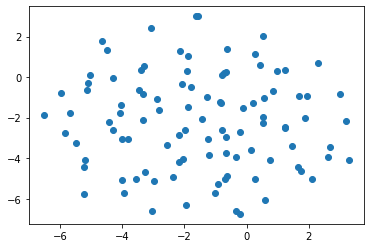

In [69]:
fig, ax = plt.subplots()
ax.scatter(tsne_coords[:,0], tsne_coords[:,1])

An alternative method (and competitor) is umap

In [70]:
umap_coords = umap.UMAP(metric="precomputed").fit_transform(scikit_distances)

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


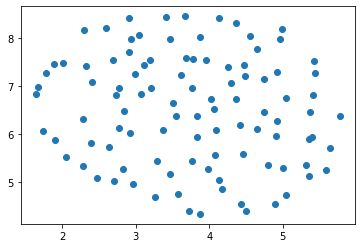

In [72]:
fig, ax = plt.subplots()
ax.scatter(umap_coords[:,0], umap_coords[:,1])